In [1]:
# standard imports
import numpy as np
import math
import os
import csv
from tqdm import tqdm
import meshio
import matplotlib.pyplot as plt

In [5]:
# custom class imports
from node import node
from cell import cell
from mesh import exp_mesh
from derivatives import derivatives
from fluid_problem import inc_fluid_problem

# utility functions
from utilities import *

# Loading Filedata

In [3]:
# reading file data
data_dir="./lam_cyl_inc_air/restart/"
data_dict = get_inc_flow_data(data_dir,2900,1,1100) # entspricht einer festen Anzahl Ablösungsperioden

100%|██████████| 1100/1100 [03:37<00:00,  5.06it/s]


# Setting Problem, work in progress

In [6]:
# read su2 mesh file
meshio_mesh = meshio.read("./lam_cyl_inc_air/mesh_cylinder_quad.su2",file_format="su2")
# define mid point for rotational symmetric mesh
mid_point = np.array([0.5,0]) 
# convert mesh into custom class exp_mesh
mesh = exp_mesh(meshio_mesh,mid_point)
# declare problem instance
test = inc_fluid_problem(mesh)

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2


# POD Decomposition

In [7]:
# configure data 
q = np.vstack([data_dict["u"],data_dict["v"],data_dict["p"]])
q_avg = np.mean(q,1)
q_fluc = q - np.repeat(np.expand_dims(q_avg,1),q.shape[1],axis=1)

U, S, Vh = np.linalg.svd(q_fluc, full_matrices=False)

# reconstruction threshold
epsilon = 0.97 # [0,1]
acc = 0
num = 0
while acc < epsilon:
    num+=1
    acc = sum(S[:num])/sum(S)    
print("Number of eigenvectors necessary for thresholded reconstruction: \t" + str(num))

coeffs = np.matmul(np.transpose(U[:,:num]),q_fluc)

Number of eigenvectors necessary for thresholded reconstruction: 	6


In [6]:
x,y = get_x_y(data_dir)
plot_eigenflows(x,y,U,mesh.n,num)

AttributeError: type object 'mesh' has no attribute 'n'

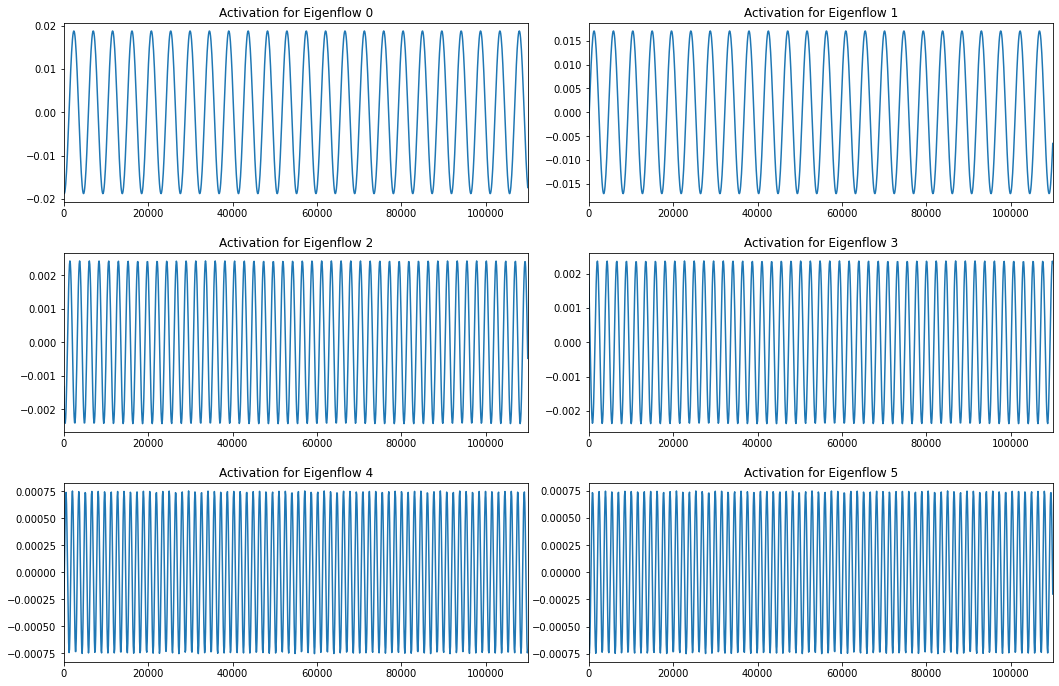

In [16]:
# coefficients for given timeframe t = 0,...,T
coeffs = np.matmul(np.transpose(U[:,:num]),q_fluc)

# set timestep 
dt = 100
t = np.linspace(0,(U.shape[1]-1)*dt,U.shape[1])

# Galerkin model based on discrete reconstruction as q = \bar{q}+\sum_i^n a_i(t)*\phi_i(x)
fig,ax = plt.subplots(3,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

# add plots over full time domain
ax[0][0].plot(t,coeffs[0,:])
ax[0][1].plot(t,coeffs[1,:])
ax[1][0].plot(t,coeffs[2,:])
ax[1][1].plot(t,coeffs[3,:])
ax[2][0].plot(t,coeffs[4,:])
ax[2][1].plot(t,coeffs[5,:])

# set fixed time window to plot
ax[0][0].set_xlim([0,t[-1]])
ax[0][1].set_xlim([0,t[-1]])
ax[1][0].set_xlim([0,t[-1]])
ax[1][1].set_xlim([0,t[-1]])
ax[2][0].set_xlim([0,t[-1]])
ax[2][1].set_xlim([0,t[-1]])

# Set titles
ax[0][0].title.set_text("Activation for Eigenflow 0")
ax[0][1].title.set_text("Activation for Eigenflow 1")
ax[1][0].title.set_text("Activation for Eigenflow 2")
ax[1][1].title.set_text("Activation for Eigenflow 3")
ax[2][0].title.set_text("Activation for Eigenflow 4")
ax[2][1].title.set_text("Activation for Eigenflow 5")

# Reconstruction of data

In [8]:
# reconstruction 
rec = np.zeros(q.shape)
rec += np.repeat(np.expand_dims(q_avg,1),coeffs.shape[1],1)
rec +=  np.matmul(U[:,:num],coeffs[:num,:])

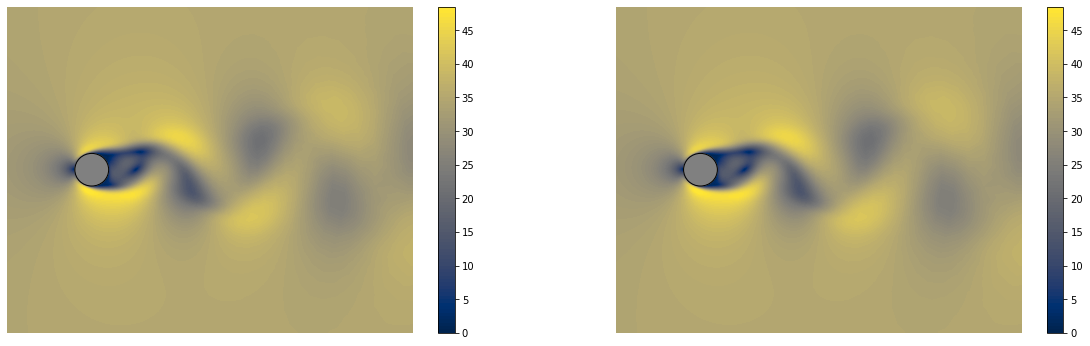

In [9]:
n = mesh.n
sample = 1
# computing total velocity!
data = np.sqrt(np.multiply(rec[:n,sample],rec[:n,sample])+np.multiply(rec[n:2*n,sample],rec[n:2*n,sample]))
real_data = np.sqrt(np.multiply(q[:n,sample],q[:n,sample])+np.multiply(q[n:2*n,sample],q[n:2*n,sample]))
# visualizing
fig,ax = plt.subplots(1,2,figsize=(20,6))
plot_cylinder(x,y,data,cmap=get_cmap(False),ax=ax[0],clip=False)
plot_cylinder(x,y,real_data,cmap=get_cmap(False),ax=ax[1],clip=False)

## Galerkin System

In [10]:
# Computation of Galerkin system parameters
Qavg = test.Q_operator(q_avg,q_avg)
Lavg = test.L_operator(q_avg)

# initialie arrays for parameters
b1 = np.empty(num)
b2 = np.empty(num)
L1 = np.empty((num,num))
L2 = np.empty((num,num))
Q = [np.empty((num,num,)) for x in range(num)]

# defining parameter files
coef_dir = "./coefficients_2/"
b1_filename = coef_dir+"b1"
b2_filename = coef_dir+"b2"
L1_filename = coef_dir+"L1"
L2_filename = coef_dir+"L2"
Q_filename = coef_dir+"Q"

# set computation flag
compute_coefficients = True

if os.path.exists(b1_filename):
    b1 = np.load(b1_filename)
if os.path.exists(b2_filename):
    b2 = np.load(b2_filename)
if os.path.exists(L1_filename):
    L1 = np.load(L1_filename)
if os.path.exists(L2_filename):
    L2 = np.load(L2_filename)
if os.path.exists(Q_filename):
    Q = np.load(Q_filename) 

if compute_coefficients:
    Q_tmp1 = np.empty((num,3*len(mesh.cells)))
    Q_tmp2 = np.empty((num,3*len(mesh.cells)))
    Q_tmp3 = np.empty((num,num,3*len(mesh.cells)))
    L_tmp = np.empty((num,3*len(mesh.cells)))
    for i in tqdm(range(num)):
        Q_tmp1[i] = test.Q_operator(q_avg,U[:,i])
        Q_tmp2[i] = test.Q_operator(U[:,i],q_avg)
        L_tmp[i] = test.L_operator(U[:,i])
        for j in range(num):
            Q_tmp3[i,j] = test.Q_operator(U[:,i],U[:,j])
    for k in tqdm(range(num)):
        b1[k] = test.compute_inner_product(Lavg,U[:,k])
        b2[k] = test.compute_inner_product(Qavg,U[:,k])
        for i in range(num):
            L1[k,i] = test.compute_inner_product(L_tmp[i],U[:,k])
            L2[k,i] = test.compute_inner_product(Q_tmp1[i]+Q_tmp2[i],U[:,k])
            for j in range(num):
                Q[k][i,j] = test.compute_inner_product(Q_tmp3[i,j],U[:,k])
        
    # saving coefficient arrays to files
    np.save(b1_filename,b1)
    np.save(b2_filename,b2)
    np.save(L1_filename,L1)
    np.save(L2_filename,L2)
    np.save(Q_filename,Q)

100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


# Solving ODE system

In [11]:
# initial conditions for the activations are obtained as activations on the initial timeframe of the data matrix
a0 = coeffs[:,0] #initial conditions
dt = 0.1
t0 = 0
tmax = 500
sampling_span = np.linspace(t0,tmax-dt,num=int(tmax/dt))
# static viscosity
nu = 1.516e-5

# defining ode function
def galerkin_system(t,a):
    # set global variables references
    global Q, L1, L2, b1, b2, nu
    a_dot = np.empty_like(a)
    for k in range(a_dot.shape[0]):
        # the vector notation makes np.matmul automatically reduce to a one dimensional output therefore normal multiplication can be used to get vector shape
        # the indexed vectors L1 and L2 form columnvectors (automatically)
        a_dot[k] = nu * b1[k] + b2[k] + np.matmul((nu*L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q[k]),np.expand_dims(a,1))
    return a_dot.flatten()

# euler-forward ode
def euler_galerkin_system(dt,ak):
    # set global variables references
    global Q, L1, L2, b1, b2, nu
    akp1 = np.empty_like(ak)
    for k in range(akp1.shape[0]):
        # the vector notation makes np.matmul automatically reduce to a one dimensional output therefore normal multiplication can be used to get vector shape
        # the indexed vectors L1 and L2 form columnvectors (automatically)
        akp1[k] = ak[k] + dt * (nu * b1[k] + b2[k] + np.matmul((nu*L1[k,:]+L2[k,:]),ak) + np.matmul(np.matmul(np.expand_dims(ak,1).T,Q[k]),np.expand_dims(ak,1)))
    return akp1.flatten()  

In [12]:
# coefficient matrix
galerkin_activations = np.empty((coeffs.shape[0],int(tmax/dt)))
galerkin_activations[:,0] = a0
# solver iteration
t = dt
for i in range(1,tmax):
    galerkin_activations[:,i] = euler_galerkin_system(dt,galerkin_activations[:,i-1])
    t+=dt

In [13]:
from scipy.integrate import solve_ivp

sol = solve_ivp(galerkin_system,(t0,tmax),a0,method='LSODA',t_eval=sampling_span,atol=1e-12,rtol=1e-12)
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 680
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.000e+00, 1.000e-01, 2.000e-01, ..., 4.997e+02, 4.998e+02,
       4.999e+02])
 t_events: None
        y: array([[-6.58004200e+02, -6.58436316e+02, -6.58868489e+02, ...,
        -5.48561359e+04, -5.48423295e+04, -5.48261195e+04],
       [-2.89137970e+02, -2.89986273e+02, -2.90834716e+02, ...,
        -8.30055082e+04, -8.31136789e+04, -8.32199461e+04],
       [ 2.28463772e+01,  2.29552996e+01,  2.30642010e+01, ...,
        -4.97695768e+04, -4.99721463e+04, -5.01749059e+04],
       [-8.12249552e+01, -8.12904270e+01, -8.13559109e+01, ...,
         3.97639480e+04,  3.99499170e+04,  4.01362594e+04],
       [ 8.64011150e+00,  8.59571374e+00,  8.55130906e+00, ...,
        -3.44003946e+03, -3.42215580e+03, -3.40390291e+03],
       [-2.09459777e+01, -2.09442346e+01, -2.09424941e+01, ...,
         1.14895649e+03,

In [14]:
def reconstruct_flow(activations,U,avg,num,rang=(0,100)):
    low,high = rang
    flow = np.repeat(np.expand_dims(avg,1),high-low,1)
    for i in range(num):
         flow += np.outer(U[:,i],activations[i,low:high])
    return flow

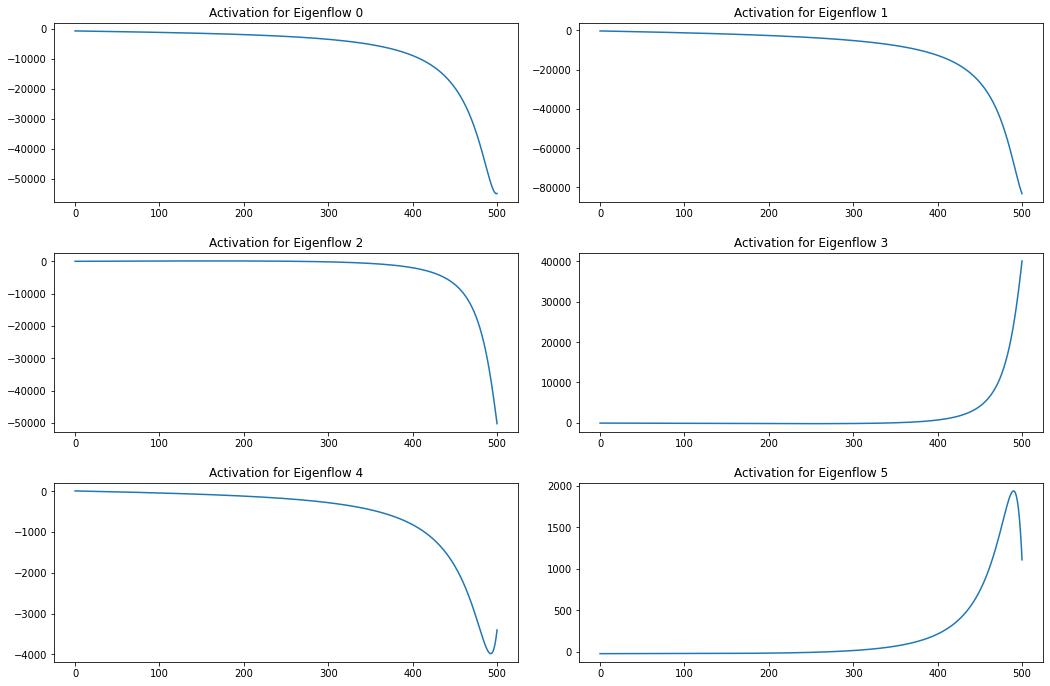

In [15]:
# Galerkin model based on discrete reconstruction as q = \bar{q}+\sum_i^n a_i(t)*\phi_i(x)
fig,ax = plt.subplots(3,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

t = sampling_span

# add plots over full time domain
ax[0][0].plot(t,sol.y[0,:len(t)])
ax[0][1].plot(t,sol.y[1,:len(t)])
ax[1][0].plot(t,sol.y[2,:len(t)])
ax[1][1].plot(t,sol.y[3,:len(t)])
ax[2][0].plot(t,sol.y[4,:len(t)])
ax[2][1].plot(t,sol.y[5,:len(t)])

# set fixed time window to plot
#ax[0][0].set_xlim([0,500])
#ax[0][1].set_xlim([0,500])
#ax[1][0].set_xlim([0,500])
#ax[1][1].set_xlim([0,500])
#ax[2][0].set_xlim([0,500])
#ax[2][1].set_xlim([0,500])

# set fixed time window to plot
#ax[0][0].set_ylim([-1,1])
#ax[0][1].set_ylim([-1,1])
#ax[1][0].set_ylim([-1,1])
#ax[1][1].set_ylim([-1,1])
#ax[2][0].set_ylim([-1,1])
#ax[2][1].set_ylim([-1,1])

# Set titles
ax[0][0].title.set_text("Activation for Eigenflow 0")
ax[0][1].title.set_text("Activation for Eigenflow 1")
ax[1][0].title.set_text("Activation for Eigenflow 2")
ax[1][1].title.set_text("Activation for Eigenflow 3")
ax[2][0].title.set_text("Activation for Eigenflow 4")
ax[2][1].title.set_text("Activation for Eigenflow 5")

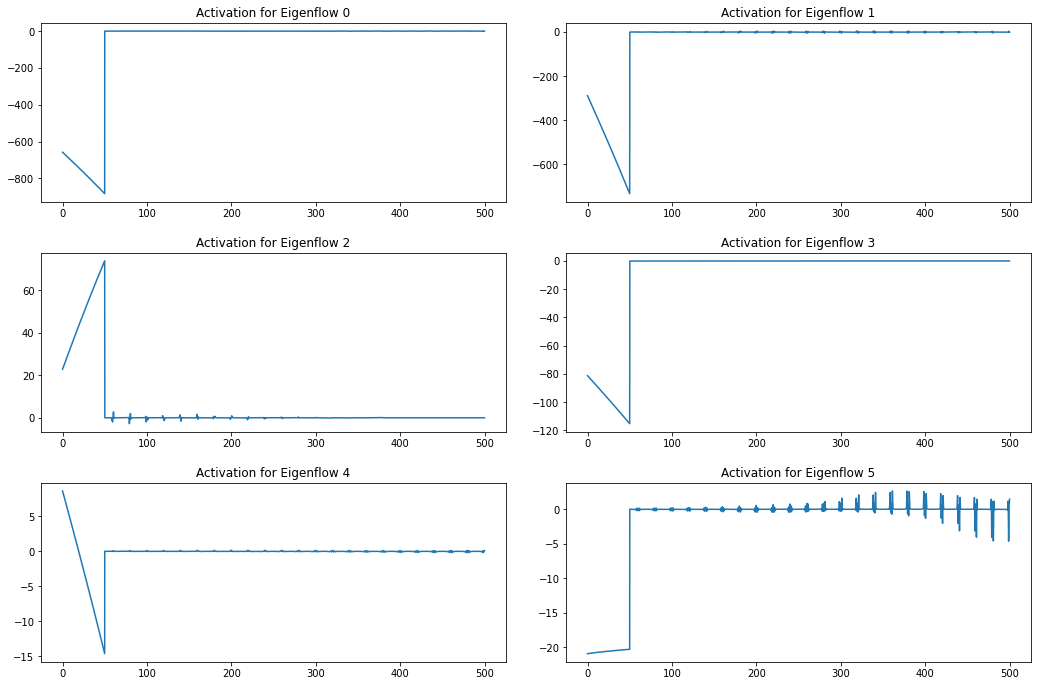

In [16]:
# Galerkin model based on discrete reconstruction as q = \bar{q}+\sum_i^n a_i(t)*\phi_i(x)
fig,ax = plt.subplots(3,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

t = sampling_span

# add plots over full time domain
ax[0][0].plot(t,galerkin_activations[0,:len(t)])
ax[0][1].plot(t,galerkin_activations[1,:len(t)])
ax[1][0].plot(t,galerkin_activations[2,:len(t)])
ax[1][1].plot(t,galerkin_activations[3,:len(t)])
ax[2][0].plot(t,galerkin_activations[4,:len(t)])
ax[2][1].plot(t,galerkin_activations[5,:len(t)])

# set fixed time window to plot
#ax[0][0].set_xlim([0,500])
#ax[0][1].set_xlim([0,500])
#ax[1][0].set_xlim([0,500])
#ax[1][1].set_xlim([0,500])
#ax[2][0].set_xlim([0,500])
#ax[2][1].set_xlim([0,500])

# set fixed time window to plot
#ax[0][0].set_ylim([-1,1])
#ax[0][1].set_ylim([-1,1])
#ax[1][0].set_ylim([-1,1])
#ax[1][1].set_ylim([-1,1])
#ax[2][0].set_ylim([-1,1])
#ax[2][1].set_ylim([-1,1])

# Set titles
ax[0][0].title.set_text("Activation for Eigenflow 0")
ax[0][1].title.set_text("Activation for Eigenflow 1")
ax[1][0].title.set_text("Activation for Eigenflow 2")
ax[1][1].title.set_text("Activation for Eigenflow 3")
ax[2][0].title.set_text("Activation for Eigenflow 4")
ax[2][1].title.set_text("Activation for Eigenflow 5")

In [17]:
rec = reconstruct_flow(galerkin_activations,U,q_avg,num,rang=(0,500))

In [18]:
galerkin_activations.shape

(6, 5000)

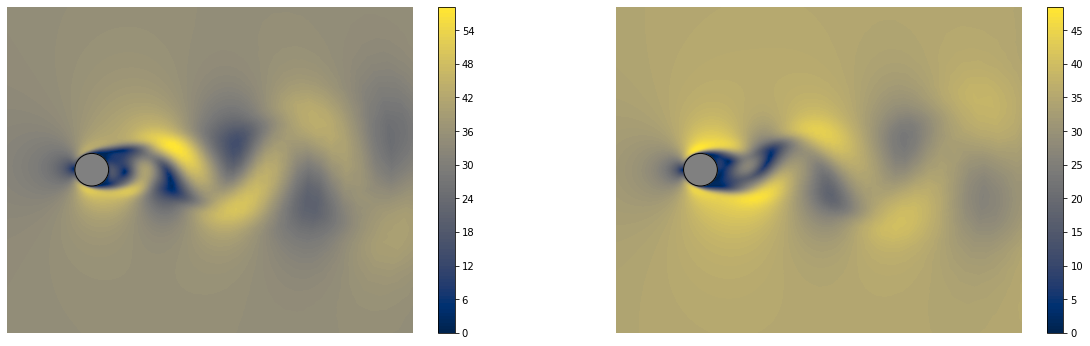

In [19]:
sample = 400
# computing total velocity!
data = np.sqrt(np.multiply(rec[:n,sample],rec[:n,sample])+np.multiply(rec[n:2*n,sample],rec[n:2*n,sample]))
real_data = np.sqrt(np.multiply(q[:n,sample],q[:n,sample])+np.multiply(q[n:2*n,sample],q[n:2*n,sample]))
# visualizing
fig,ax = plt.subplots(1,2,figsize=(20,6))
plot_cylinder(x,y,data,cmap=get_cmap(False),ax=ax[0],clip=False)
plot_cylinder(x,y,real_data,cmap=get_cmap(False),ax=ax[1],clip=False)

# Testing # cell based derivations

In [20]:
test.mesh.rads

array([ 0.5       ,  0.50198687,  0.50409036,  0.50631763,  0.50867623,
        0.5111741 ,  0.5138196 ,  0.51662154,  0.51958923,  0.52273253,
        0.52606187,  0.52958829,  0.53332344,  0.5372797 ,  0.54147013,
        0.54590859,  0.55060972,  0.55558902,  0.56086292,  0.56644878,
        0.57236499,  0.57863102,  0.58526747,  0.59229613,  0.59974009,
        0.60762378,  0.61597536,  0.62482242,  0.6341942 ,  0.64412162,
        0.65463743,  0.6657763 ,  0.67757494,  0.6900722 ,  0.70330925,
        0.71732965,  0.73217953,  0.74790776,  0.76456606,  0.78220923,
        0.80089528,  0.82068567,  0.8416455 ,  0.86384369,  0.88735328,
        0.91225163,  0.9386207 ,  0.9665473 ,  0.99612344,  1.02744656,
        1.06061996,  1.09575305,  1.13296179,  1.17236908,  1.21410514,
        1.25830798,  1.30512389,  1.35470788,  1.40722426,  1.46284721,
        1.52176131,  1.58416222,  1.65025736,  1.72026656,  1.79442286,
        1.87297328,  1.95617968,  2.04431964,  2.13768738,  2.23